## Notebook 1 - Experiment Phase

##### Please ensure notebook '0_initialize_dependencies.ipynb' has finished executing the install scripts before you start with this notebook

##### This notebook shall be used as a second step to experiment running distributed training using PyTorch Training Operators on Kuberntes. 

##### This notebook is designed to create the PyTorchJob custom resource manifest using Kubeflow training and Kubernetes python clients. The PyTorch Training Operators makes it easy to run distributed or non-distributed PyTorch jobs on Kubernetes. However, please feel free to log in to cloud9 or other clients  which connect to your Kubernetes cluster to run kubectl commands 

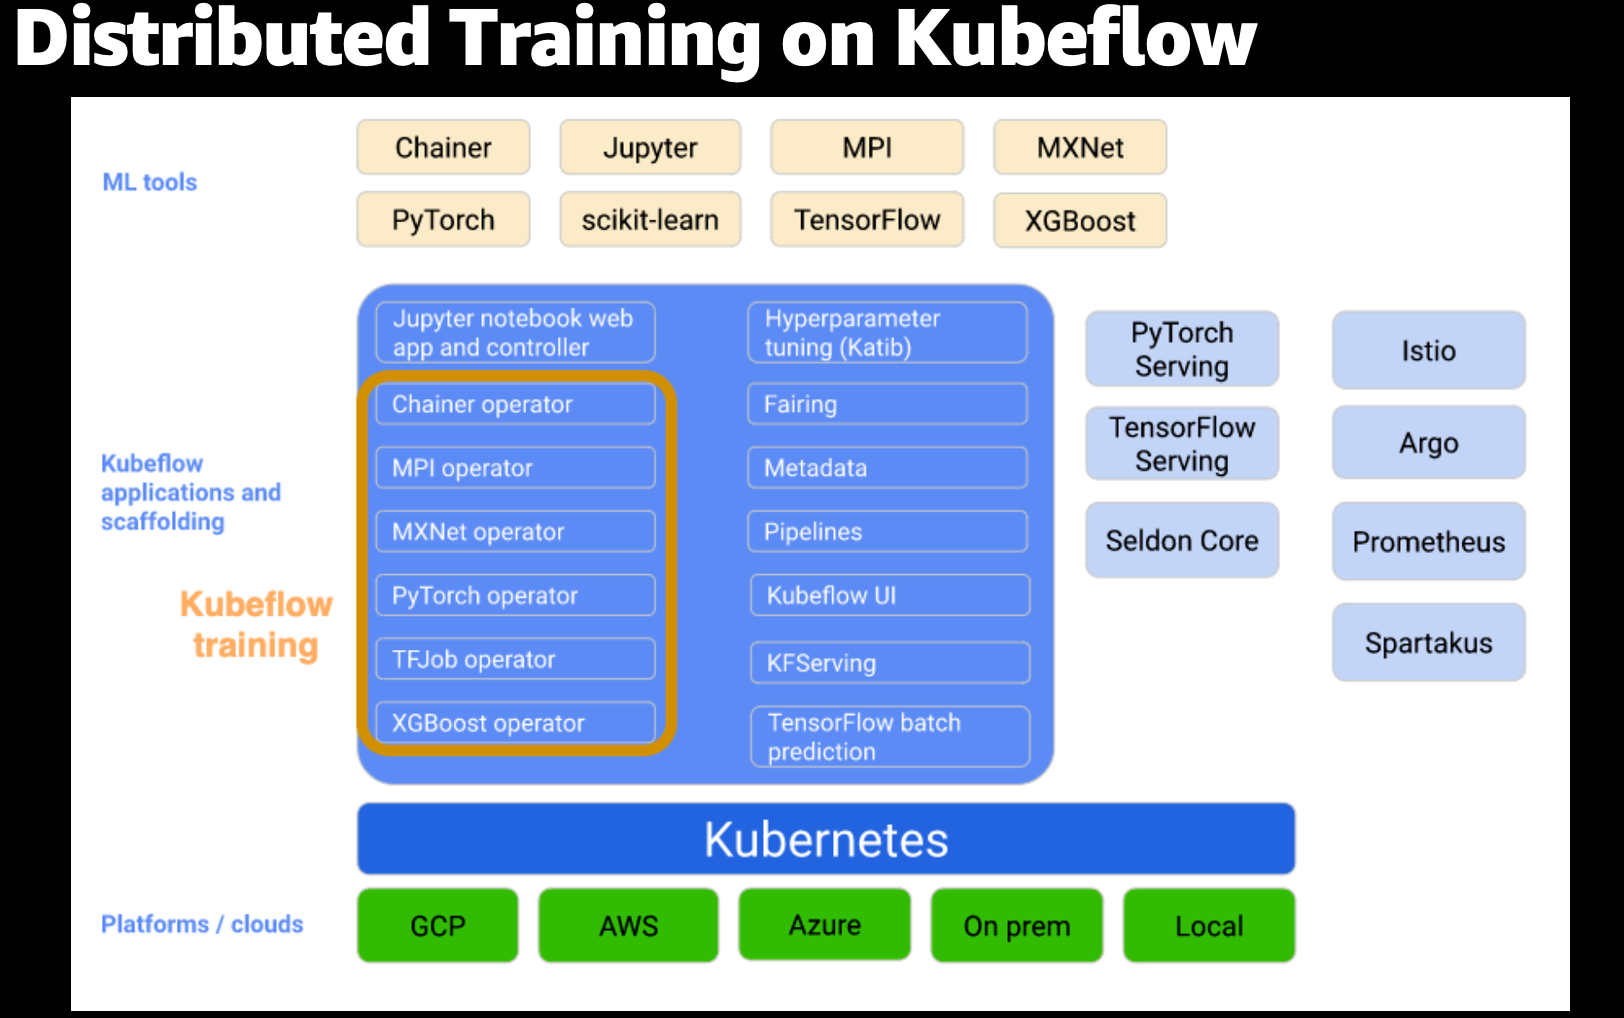

In [ ]:
# Install Kubernetes client and kubeflow training operator pythion libraries. We will use this to create PyTorchJob manifest yaml file 

from kubernetes.client import V1PodTemplateSpec
from kubernetes.client import V1ObjectMeta
from kubernetes.client import V1PodSpec
from kubernetes.client import V1Container
from kubernetes.client import V1ResourceRequirements
from kubernetes.client import V1VolumeMount
from kubernetes.client import V1Volume
from kubernetes.client import V1PersistentVolumeClaimVolumeSource

from kubeflow.training import constants
from kubeflow.training.utils import utils
from kubeflow.training import V1ReplicaSpec
from kubeflow.training import V1PyTorchJob
from kubeflow.training import V1PyTorchJobSpec
from kubeflow.training import PyTorchJobClient
from kubeflow.training import V1RunPolicy

import kfp
from kfp import components

from kfp import dsl
from kfp import compiler
from pytorch_dist_utility import *
import time,os
import boto3
from datetime import datetime

# If you get any import error then please do restart the Kernel (Go to 'Kernel' Menu -> Click 'Restart Kernel...')

In [ ]:
# Initialize global variables 

user_namespace = utils.get_default_target_namespace()

pytorch_distributed_jobname=f'pytorch-cnn-dist-job-{time.strftime("%Y-%m-%d-%H-%M-%S-%j", time.gmtime())}'

efs_mount_point='efs-sc-claim'

aws_dlc_pytorch_gpu_image='763104351884.dkr.ecr.us-west-2.amazonaws.com/pytorch-training:1.12.0-cpu-py38-ubuntu20.04-e3'

In [ ]:
# Create S3 bucket. Create it once and then use the same name for experiments. 
timsestamp = datetime.now().strftime('%Y%m%d%H%M%S')

region='us-west-2'
s3 = boto3.client('s3', region_name=region)
location = {'LocationConstraint': region}

#s3_bucket_name='kserve-model-'+timsestamp
#s3.create_bucket(Bucket=s3_bucket_name,CreateBucketConfiguration=location)
s3_bucket_name='kserve-model-20230526045744'

In [ ]:
user_namespace

In [ ]:
# Copy the training script to the EFS mount path location 

ROOT_DIR = os.path.abspath('/home/jovyan')

efs_mount_dir=ROOT_DIR+'/' + efs_mount_point

print(efs_mount_dir)

!cp cifar10-distributed-gpu-final.py $efs_mount_dir/

In [ ]:
import torchvision

cifar10_dataset = torchvision.datasets.CIFAR10(efs_mount_dir+'/cifar10-dataset', 
                                     train=True, 
                                     download=True)

#datasets

## Create PyTorch Job CRD Yaml File

In [ ]:
# Create Volume specification for PyTorchJob to be claimed by master and worker pods 

persistent_vol_claim = V1PersistentVolumeClaimVolumeSource(
    claim_name=efs_mount_point
)

efs_volume = V1Volume(
    name=efs_mount_point,
    persistent_volume_claim=persistent_vol_claim
)

In [ ]:
# Create container specification for PyTorchJob master and worker pods 

# Mount volume to container pods
efsvolumemount = V1VolumeMount(
    mount_path=efs_mount_point,
    name=efs_mount_point
)

# Resource configuration for master and worker containers
resource_reqs = V1ResourceRequirements(
    limits={'cpu':'1'}
)

# Create master and worker container spec 
container = V1Container(
    name="pytorch",
    image=aws_dlc_pytorch_gpu_image,
    args=["python","./"+efs_mount_point+"/cifar10-distributed-gpu-final.py","--epochs","1","--seed","7","--log-interval","60","--efs-mount-path",efs_mount_point,"--efs-dir-path","cifar10-dataset","--s3bucket",s3_bucket_name],    
    volume_mounts=[efsvolumemount],
    resources=resource_reqs
)

In [ ]:
# Create master specification 
master = V1ReplicaSpec(
    replicas=1,
    restart_policy="OnFailure",
    template=V1PodTemplateSpec(
        metadata=V1ObjectMeta(
            annotations={'sidecar.istio.io/inject': 'false'}
        ),
        spec=V1PodSpec(
            containers=[container],
            volumes=[efs_volume]
        )
    )
)

# Create worker specification 
worker = V1ReplicaSpec(
    replicas=2, # How many gpus or cpus shall be needed to distribute the training across
    restart_policy="OnFailure",
    template=V1PodTemplateSpec(
        metadata=V1ObjectMeta(
            annotations={'sidecar.istio.io/inject': 'false'}
        ),
        spec=V1PodSpec(
            containers=[container],
            volumes=[efs_volume]
        )
    )
)


In [ ]:
# Define PyTorchJob custom resource manifest 
pytorchjob = V1PyTorchJob(
    api_version="kubeflow.org/v1",
    kind="PyTorchJob",
    metadata=V1ObjectMeta(name=pytorch_distributed_jobname,namespace=user_namespace),
    spec=V1PyTorchJobSpec(
        run_policy=V1RunPolicy(clean_pod_policy="None"),
        pytorch_replica_specs={"Master": master,
                               "Worker": worker}
    )
)

In [ ]:
pytorchjob_client = PyTorchJobClient()

try:
  if(pytorchjob_client.get(pytorch_distributed_jobname, namespace=user_namespace)):
    pytorchjob_client.delete(pytorch_distributed_jobname)
    print("Existing job: %s deleted"%(pytorch_distributed_jobname))
except:
  print("There is no existing job: %s. Please go ahead and create a new one"%(pytorch_distributed_jobname))

In [ ]:
# Creates and Submits PyTorchJob custom resource file to Kubernetes
pytorch_job_manifest=pytorchjob_client.create(pytorchjob)

In [ ]:
# Print the submitted PyTorchJob custom resource file for reference 

# pytorch_job_manifest

In [ ]:
# Function Definition: def save_master_worker_spec(pytorch_client: PyTorchJobClient, pytorch_jobname: str) -> str:
#   Function also extracts master and worker spec that could be used for the creating the pipeline 

save_master_worker_spec(pytorchjob_client, pytorch_distributed_jobname)

In [ ]:
#  Function Definition: read_logs(pyTorchClient: str, jobname: str, namespace: str, log_type: str) -> None:
#    log_type: all, worker:all, master:all, worker:0, worker:1

read_logs(pytorchjob_client, pytorch_distributed_jobname, user_namespace, "master:0")

# Useful Commands to run on Kubernetes control plane or in notebook using !. Substitute your namespace and pod names
#  !kubectl get pods -n <aws-hybrid-training-ns>  
#  !kubectl logs <pod-name> -n <aws-hybrid-training-ns> -f

In [ ]:
# Check if the job succeeded

pytorchjob_client.is_job_succeeded(pytorch_distributed_jobname, user_namespace)

# CleanUp

In [ ]:
# Delete all previously submitted PyTorchJobs through this command. You can run in notebook as well on kubernetes cli. 

#!kubectl get pytorchjob --no-headers=true -A | awk '/pytorch-cnn-dist/{print $2}' | xargs kubectl delete pytorchjob -n kubeflow-user-example-com       